<h1><center>Author: Vyom Chopra</center></h1>
<h1><center>Roll No: 101917060</center></h1>
<h1><center>Group: 4CSE3</center></h1>

##### *I have used Light Gradient Boosting Machine for solving the time series prediction problem of the given dataset*

#### Step 1: Data Gathering

In [1]:
# Importing all the necessary modules and libraries
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import warnings

# I don't want unnecessary warnings
warnings.filterwarnings("ignore")

In [7]:
# Read the dataset
df = pd.read_excel('DATASET.xlsx')
df.head()

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.52
1,NaN,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.62
2,NaN,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.68
3,NaN,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.78
4,NaN,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.80


#### Step 2: Data Preprocessing

In [8]:
# Remove anomolies of sections
clear_idx = 910
lst_to_clear = []
for i in range(9):
  lst_to_clear.append(clear_idx+i)

df.fillna(0, inplace = True)
df.drop(lst_to_clear, inplace = True)

# Rename column to section_name
df.rename(columns = {'Unnamed: 0':'Section_name'}, inplace = True)

# Assigning section names to all the records
mul = 10
j = 0
for i in range(100):
  sec_name = df.iloc[j,0]
  df.iloc[j:j + mul, 0] = sec_name
  j += mul

# Getting the testing frames
test_frames = df.loc[df['year'] == 10]

# Verifying the changes
df.head()

,Section_name,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.52
1,Sec_1,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.62
2,Sec_1,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.68
3,Sec_1,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.78
4,Sec_1,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.80


#### Step 3: Train and Test Data Preparation

In [17]:
# Extract the training part of input dataset
move = 9 # total 9 records per section are training frames
def extract_xtrain(df, row_start, col_start):
  row_end = row_start + move
  return df.iloc[row_start:row_end, 1:10]

# Extract the training part of output dataset
def extract_ytrain(df, row_start, col_start):
  row_end = row_start + move
  return df.iloc[row_start:row_end, col_start]

# Extract the testing part of input dataset
def extract_xtest(df, row_start):
  row_end = row_start + move
  return df.iloc[row_end, 1:10].to_numpy()

# Extract the output part of ouput dataset
def extract_ytest(df, row_start, col_start):
  row_end = row_start + move
  return df.iloc[row_end, col_start]

# Get the XY Split
column_name = ["Para-"+str(i) for i in range(9,14)]
XY = []
def getXYsplit(df, row_start, row_end):
  XY = []
  XY.append(extract_xtrain(df, row_start, row_end))
  XY.append(extract_ytrain(df, row_start, row_end))
  XY.append(extract_xtest(df,row_start))
  XY.append(extract_ytest(df,row_start,row_end))
  return XY

#### Step 4: Model Training and Testing

In [18]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(random_state=19)

In [19]:
from collections import defaultdict
# Create a dictionary for storing predicted and true values
pred_values = defaultdict(lambda : [])

In [23]:
# function to calcuate mean square error
def calcuate_lmse(predict_val, test_val):
  pred_diff = predict_val - test_val
  return (pred_diff)**2

# Declaring and initializing variables
target_col = list(np.arange(10,15))
root_mean_square_error = []
total_count = 0
curr_section = 0
total_squared_error = 0
max_val = 1000

for j in target_col:
  local_squared_error = 0
  l_count = 0
  LXY = [0,0,0,0]
  for i in range(0, max_val, 10):
    LXY = getXYsplit(df,i,j)
    x_train, y_train,x_test,y_test = LXY[0],LXY[1],LXY[2],LXY[3]

    # fit the model and predict
    model.fit(x_train, y_train)
    ypred = model.predict(x_test.reshape(1,-1))[0]

    # store the predicted values
    pred_values[column_name[curr_section]].append(ypred)
    
    # store squared difference for RMSE

    # local_squared_error = calcuate_lmse(ypred, y_test) + local_squared_error
    total_squared_error = calcuate_lmse(ypred, y_test) + total_squared_error
    l_count += 1
    total_count += 1

  # root_mean_square_error.append(local_squared_error)
  curr_section += 1
predicted_df = pd.DataFrame.from_dict(pred_values)

#### Step 5: Plotting and Model Evaluation

In [25]:
# Calculate RMSE
total_rmse_by_n = total_squared_error/total_count
final_rmse = total_rmse_by_n**0.5

print("The RMSE is " + str(final_rmse))

The RMSE is 67.78317036916836


In [26]:
df

,Section_name,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.520
1,Sec_1,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.620
2,Sec_1,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.680
3,Sec_1,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.780
4,Sec_1,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,0,6,454.0,931.8,13.6,125.0,13,116,4150,830,15.1,1.8,1.0,15,1.681
1006,0,7,454.0,703.0,14.5,17.0,13,118,4150,830,24.6,7.9,2.0,15,1.838
1007,0,8,454.0,1124.1,14.9,45.0,18,117,4200,840,119.0,15.7,2.0,16,1.862
1008,0,9,454.0,1462.3,13.2,62.0,27,117,4400,720,138.2,30.5,6.0,18,1.883


In [27]:
# Get random rows for plotting
plot_row = 40

random_rows = []
for i in range(plot_row):
  random_rows.append(random.randint(0,90))


#### 1. Plot for Para-9

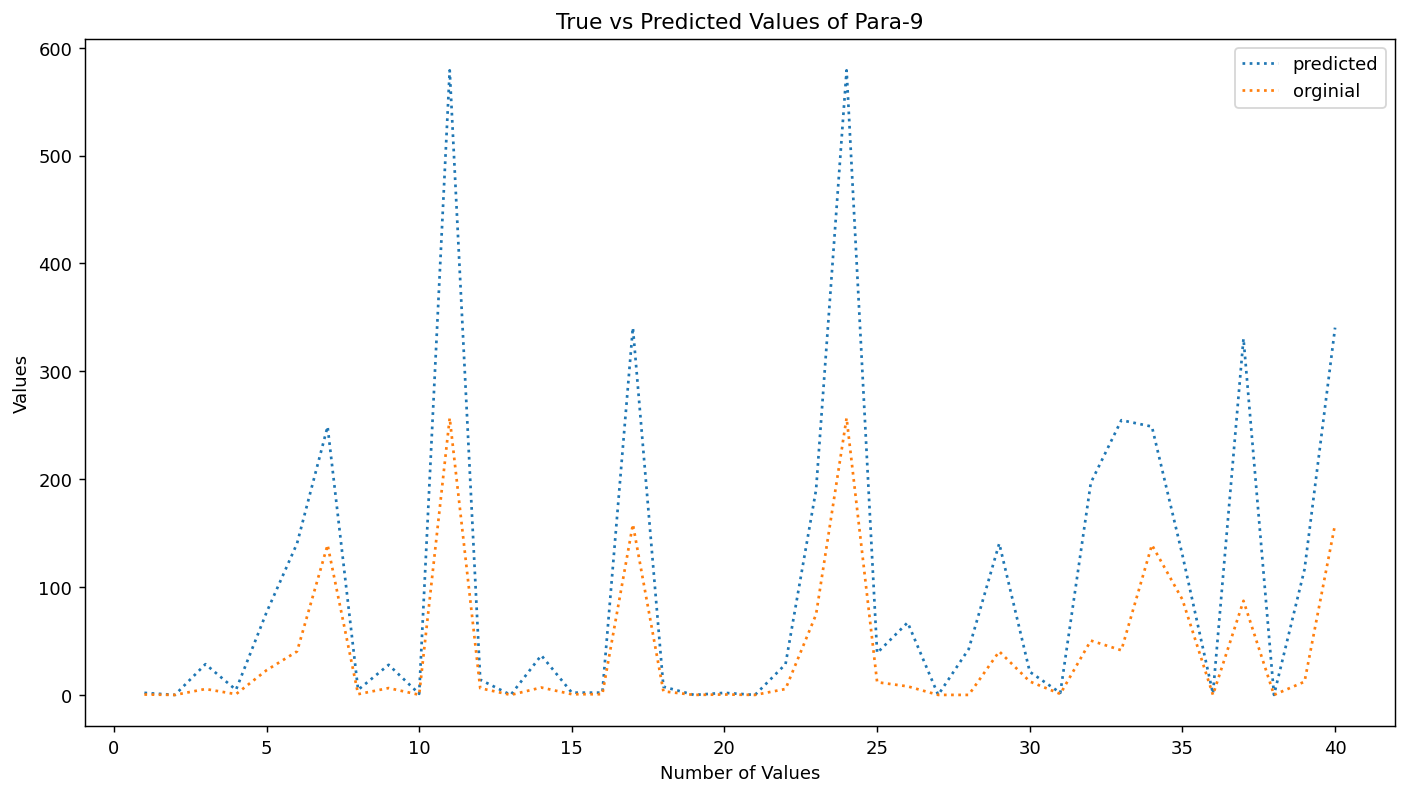

In [28]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frames.iloc[random_rows,10]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-9')
plt.legend(loc = 'upper right')

#### 2. Plot for Para-10

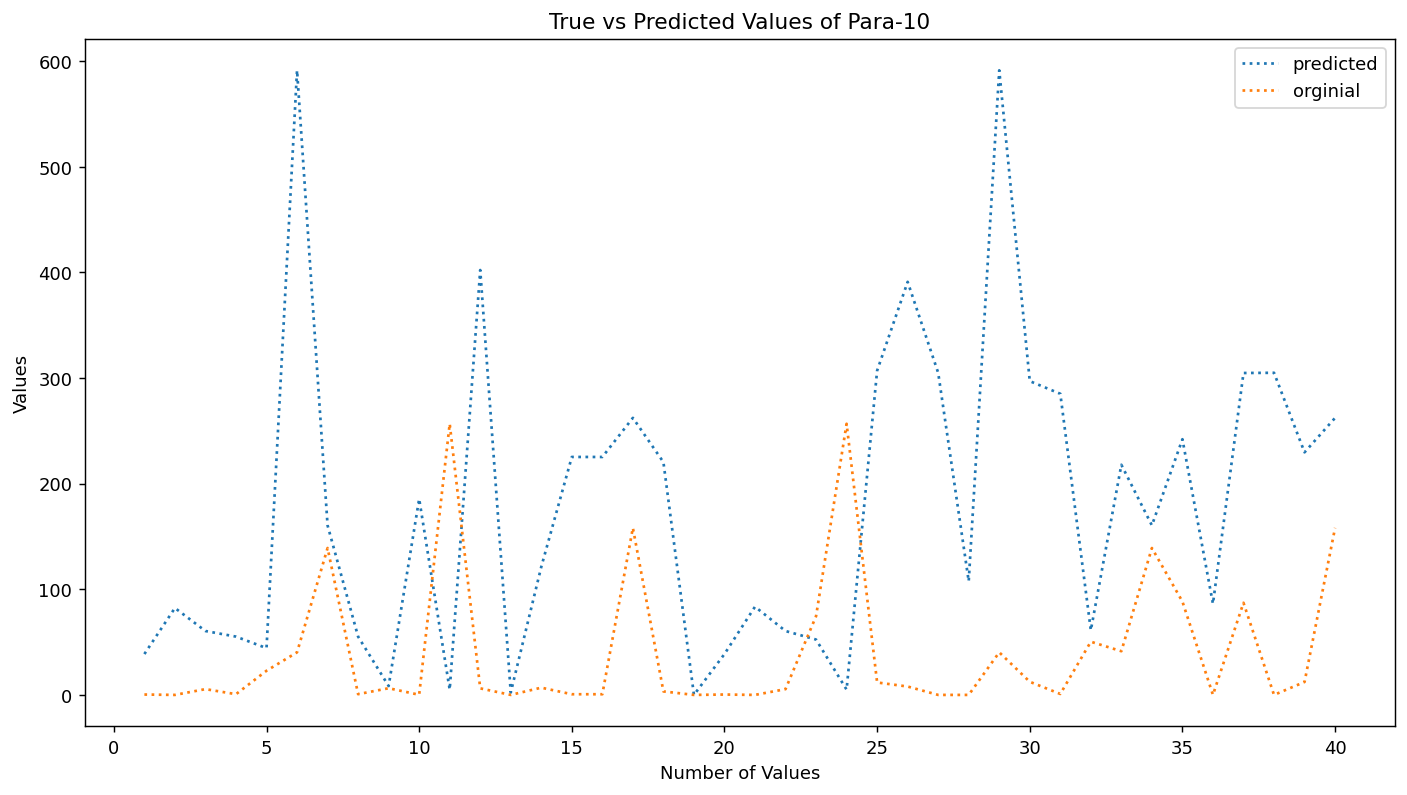

In [29]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frames.iloc[random_rows,11]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-10')
plt.legend(loc = 'upper right')

#### 3. Plot for Para-11

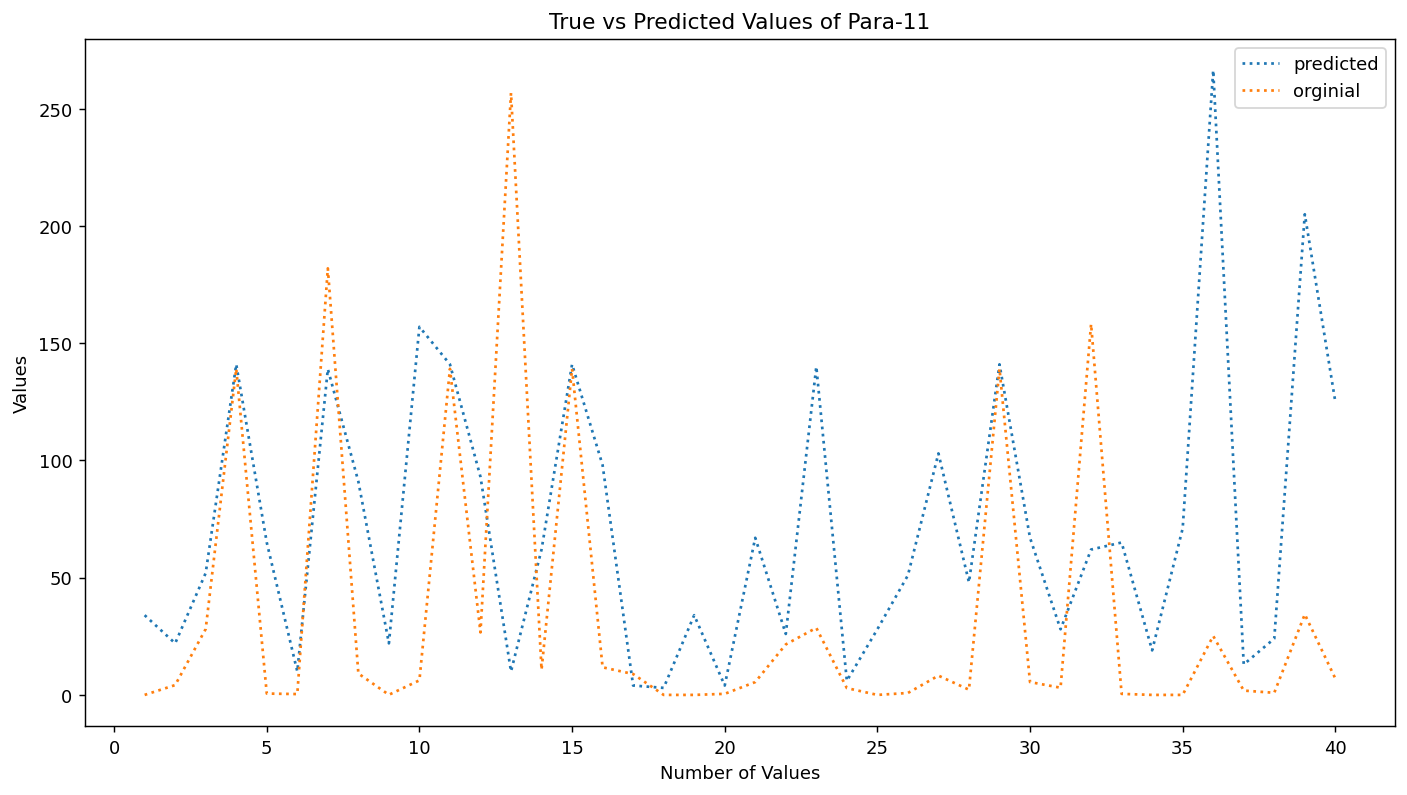

In [24]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frames.iloc[random_rows,12]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-11')
plt.legend(loc = 'upper right')

#### 4. Plot for Para-12

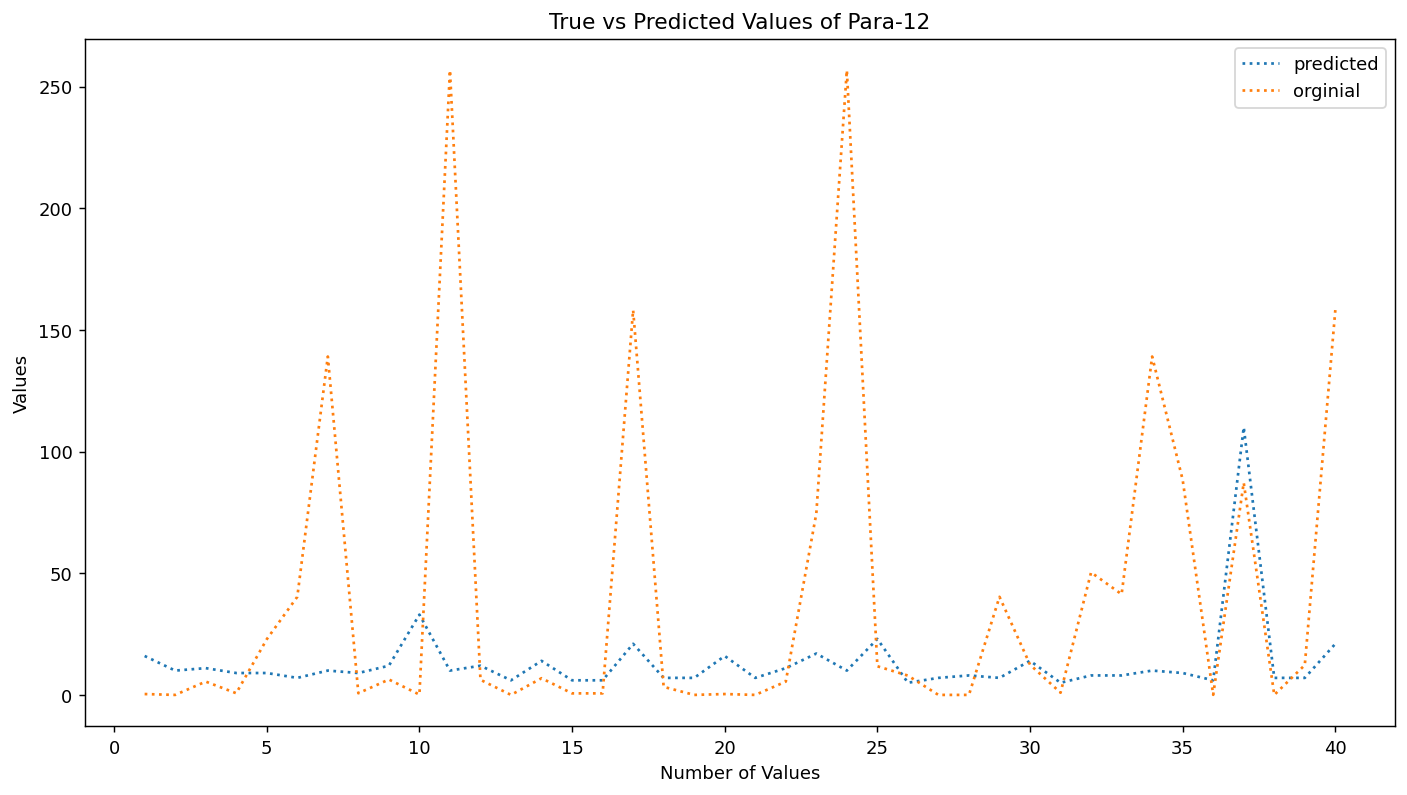

In [30]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frames.iloc[random_rows,13]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-12')
plt.legend(loc = 'upper right')

#### 5. Plot for Para-13

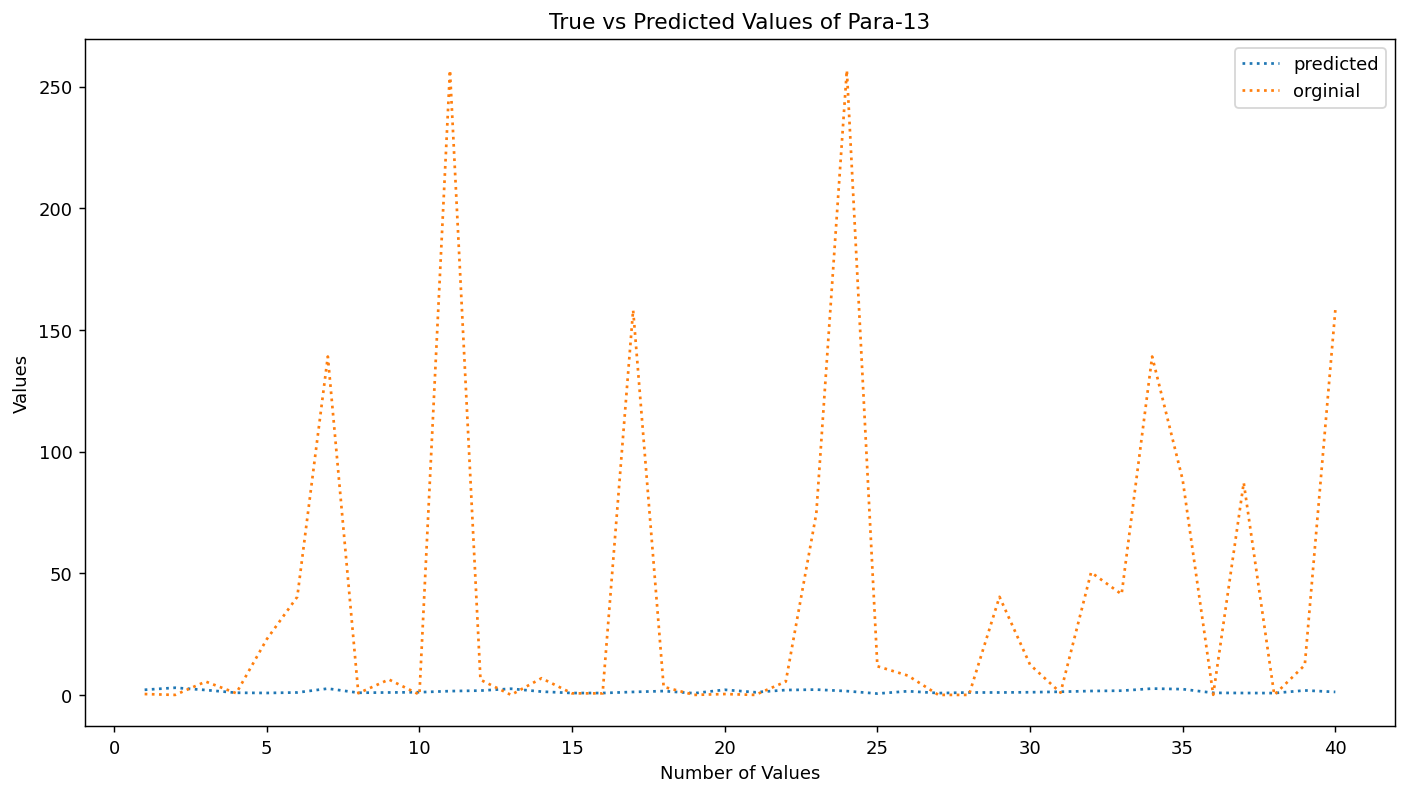

In [31]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frames.iloc[random_rows,14]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-13')
plt.legend(loc = 'upper right')